In [1]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

import gensim
import matplotlib.pyplot as plt

import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('dev.csv')
data.columns = ['Text', 'Label']
data.head(50)

,Text,Label
0,Buses approaching to this place is highly unsafe.,1
1,a man was commenting at me.,1
2,in a share auto,0
3,I was coming out of a club at night with a few...,1
4,One of my friends was molested in the crowd. T...,0
5,I was travelling in metro heading to my colleg...,0
6,A guy masturbating at the roadside and ogling....,1
7,"When I was travelling in red line metro , a gu...",0
8,Late evening (around 7.30 pm) after shopping i...,0
9,For a week in the morning when I found be taki...,1


In [3]:
data.Label.unique()

array([1, 0], dtype=int64)

In [4]:
data.shape

(991, 2)

In [5]:
pos = []
neg = []
for l in data.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)

In [6]:
data['Pos']= pos
data['Neg']= neg

In [7]:
data.head()

,Text,Label,Pos,Neg
0,Buses approaching to this place is highly unsafe.,1,1,0
1,a man was commenting at me.,1,1,0
2,in a share auto,0,0,1
3,I was coming out of a club at night with a few...,1,1,0
4,One of my friends was molested in the crowd. T...,0,0,1


# Cleaning the data

In [8]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [9]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean] 

In [10]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]  
lower_tokens = [lower_token(token) for token in tokens] 

In [11]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [12]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [13]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 

In [14]:
result = [' '.join(sen) for sen in filtered_words] 

In [15]:
data['Text_Final'] = result

In [16]:
data['tokens'] = filtered_words

In [17]:
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]

In [18]:
data[:4]

,Text_Final,tokens,Label,Pos,Neg
0,buses approaching place highly unsafe,"[buses, approaching, place, highly, unsafe]",1,1,0
1,man commenting,"[man, commenting]",1,1,0
2,share auto,"[share, auto]",0,0,1
3,coming club night friends guys came stopped us...,"[coming, club, night, friends, guys, came, sto...",1,1,0


# Split data into test and train

In [19]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

In [20]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

9742 words total, with a vocabulary size of 2634
Max sentence length is 116


In [21]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

1021 words total, with a vocabulary size of 566
Max sentence length is 48


# Load Google News Word2Vec model

In [22]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [23]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

In [24]:
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

# Get Embeddings

In [25]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [26]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

# Tokenize and Pad Sequences

In [27]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 2634 unique tokens.


In [28]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [29]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(2635, 300)


In [30]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Define CNN

In [31]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [32]:
label_names = ['Pos', 'Neg']

In [33]:
y_train = data_train[label_names].values

In [34]:
x_train = train_cnn_data
y_tr = y_train

In [35]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      790500      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 49, 200)      120200      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 200)      180200      ['embedding[0][0]']              
                                                                                              

# Train CNN

In [36]:
num_epochs = 1000
batch_size = 1024

In [37]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.7443 - acc: 0.4457 - val_loss: 0.8942 - val_acc: 0.5889
Epoch 2/1000
1/1 [==============================] - 1s 668ms/step - loss: 0.9173 - acc: 0.5843 - val_loss: 0.6983 - val_acc: 0.5889
Epoch 3/1000
1/1 [==============================] - 1s 650ms/step - loss: 0.7012 - acc: 0.5943 - val_loss: 0.6504 - val_acc: 0.6222
Epoch 4/1000
1/1 [==============================] - 1s 626ms/step - loss: 0.6389 - acc: 0.6180 - val_loss: 0.6637 - val_acc: 0.6333
Epoch 5/1000
1/1 [==============================] - 1s 623ms/step - loss: 0.6485 - acc: 0.6792 - val_loss: 0.6684 - val_acc: 0.6000
Epoch 6/1000
1/1 [==============================] - 1s 825ms/step - loss: 0.6433 - acc: 0.6642 - val_loss: 0.6548 - val_acc: 0.6778
Epoch 7/1000
1/1 [==============================] - 1s 826ms/step - loss: 0.6300 - acc: 0.7179 - val_loss: 0.6312 - val_acc: 0.7444
Epoch 8/1000
1/1 [==============================] - 1s 648ms/step - loss: 0.596

Epoch 63/1000
1/1 [==============================] - 1s 676ms/step - loss: 0.0367 - acc: 0.9863 - val_loss: 0.7792 - val_acc: 0.7889
Epoch 64/1000
1/1 [==============================] - 1s 720ms/step - loss: 0.0357 - acc: 0.9863 - val_loss: 0.7820 - val_acc: 0.7889
Epoch 65/1000
1/1 [==============================] - 1s 658ms/step - loss: 0.0378 - acc: 0.9850 - val_loss: 0.7795 - val_acc: 0.7889
Epoch 66/1000
1/1 [==============================] - 1s 641ms/step - loss: 0.0354 - acc: 0.9863 - val_loss: 0.7911 - val_acc: 0.7889
Epoch 67/1000
1/1 [==============================] - 1s 633ms/step - loss: 0.0353 - acc: 0.9850 - val_loss: 0.8041 - val_acc: 0.7889
Epoch 68/1000
1/1 [==============================] - 1s 629ms/step - loss: 0.0362 - acc: 0.9838 - val_loss: 0.8162 - val_acc: 0.7889
Epoch 69/1000
1/1 [==============================] - 1s 677ms/step - loss: 0.0314 - acc: 0.9900 - val_loss: 0.8262 - val_acc: 0.7889
Epoch 70/1000
1/1 [==============================] - 1s 658ms/step - 

1/1 [==============================] - 1s 707ms/step - loss: 0.0308 - acc: 0.9863 - val_loss: 1.0084 - val_acc: 0.7889
Epoch 125/1000
1/1 [==============================] - 1s 660ms/step - loss: 0.0348 - acc: 0.9825 - val_loss: 1.0022 - val_acc: 0.7889
Epoch 126/1000
1/1 [==============================] - 1s 660ms/step - loss: 0.0324 - acc: 0.9863 - val_loss: 0.9832 - val_acc: 0.7889
Epoch 127/1000
1/1 [==============================] - 1s 636ms/step - loss: 0.0305 - acc: 0.9875 - val_loss: 0.9650 - val_acc: 0.7889
Epoch 128/1000
1/1 [==============================] - 1s 664ms/step - loss: 0.0305 - acc: 0.9888 - val_loss: 0.9603 - val_acc: 0.7889
Epoch 129/1000
1/1 [==============================] - 1s 666ms/step - loss: 0.0304 - acc: 0.9863 - val_loss: 0.9661 - val_acc: 0.7889
Epoch 130/1000
1/1 [==============================] - 1s 664ms/step - loss: 0.0317 - acc: 0.9863 - val_loss: 0.9790 - val_acc: 0.7889
Epoch 131/1000
1/1 [==============================] - 1s 650ms/step - loss: 0

1/1 [==============================] - 1s 659ms/step - loss: 0.0294 - acc: 0.9863 - val_loss: 1.0606 - val_acc: 0.7778
Epoch 186/1000
1/1 [==============================] - 1s 658ms/step - loss: 0.0299 - acc: 0.9875 - val_loss: 1.0592 - val_acc: 0.7778
Epoch 187/1000
1/1 [==============================] - 1s 656ms/step - loss: 0.0280 - acc: 0.9838 - val_loss: 1.0593 - val_acc: 0.7778
Epoch 188/1000
1/1 [==============================] - 1s 642ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 1.0579 - val_acc: 0.7778
Epoch 189/1000
1/1 [==============================] - 1s 653ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 1.0578 - val_acc: 0.7778
Epoch 190/1000
1/1 [==============================] - 1s 664ms/step - loss: 0.0308 - acc: 0.9863 - val_loss: 1.0591 - val_acc: 0.7778
Epoch 191/1000
1/1 [==============================] - 1s 667ms/step - loss: 0.0296 - acc: 0.9850 - val_loss: 1.0601 - val_acc: 0.7778
Epoch 192/1000
1/1 [==============================] - 1s 664ms/step - loss: 0

1/1 [==============================] - 1s 685ms/step - loss: 0.0296 - acc: 0.9850 - val_loss: 1.1367 - val_acc: 0.7889
Epoch 247/1000
1/1 [==============================] - 1s 671ms/step - loss: 0.0266 - acc: 0.9875 - val_loss: 1.1419 - val_acc: 0.7889
Epoch 248/1000
1/1 [==============================] - 1s 661ms/step - loss: 0.0268 - acc: 0.9888 - val_loss: 1.1477 - val_acc: 0.7889
Epoch 249/1000
1/1 [==============================] - 1s 674ms/step - loss: 0.0266 - acc: 0.9888 - val_loss: 1.1487 - val_acc: 0.7889
Epoch 250/1000
1/1 [==============================] - 1s 660ms/step - loss: 0.0290 - acc: 0.9850 - val_loss: 1.1466 - val_acc: 0.7889
Epoch 251/1000
1/1 [==============================] - 1s 657ms/step - loss: 0.0274 - acc: 0.9888 - val_loss: 1.1456 - val_acc: 0.7889
Epoch 252/1000
1/1 [==============================] - 1s 668ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 1.1463 - val_acc: 0.7889
Epoch 253/1000
1/1 [==============================] - 1s 690ms/step - loss: 0

1/1 [==============================] - 1s 682ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 1.1799 - val_acc: 0.7889
Epoch 308/1000
1/1 [==============================] - 1s 667ms/step - loss: 0.0292 - acc: 0.9863 - val_loss: 1.1819 - val_acc: 0.7889
Epoch 309/1000
1/1 [==============================] - 1s 676ms/step - loss: 0.0283 - acc: 0.9850 - val_loss: 1.1858 - val_acc: 0.7889
Epoch 310/1000
1/1 [==============================] - 1s 686ms/step - loss: 0.0283 - acc: 0.9838 - val_loss: 1.1875 - val_acc: 0.7889
Epoch 311/1000
1/1 [==============================] - 1s 678ms/step - loss: 0.0267 - acc: 0.9888 - val_loss: 1.1909 - val_acc: 0.7889
Epoch 312/1000
1/1 [==============================] - 1s 692ms/step - loss: 0.0263 - acc: 0.9875 - val_loss: 1.1959 - val_acc: 0.7889
Epoch 313/1000
1/1 [==============================] - 1s 704ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 1.1988 - val_acc: 0.7889
Epoch 314/1000
1/1 [==============================] - 1s 674ms/step - loss: 0

1/1 [==============================] - 1s 676ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 1.2776 - val_acc: 0.7778
Epoch 369/1000
1/1 [==============================] - 1s 663ms/step - loss: 0.0298 - acc: 0.9850 - val_loss: 1.2814 - val_acc: 0.7778
Epoch 370/1000
1/1 [==============================] - 1s 670ms/step - loss: 0.0274 - acc: 0.9838 - val_loss: 1.2834 - val_acc: 0.7778
Epoch 371/1000
1/1 [==============================] - 1s 678ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 1.2858 - val_acc: 0.7778
Epoch 372/1000
1/1 [==============================] - 1s 687ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 1.2838 - val_acc: 0.7778
Epoch 373/1000
1/1 [==============================] - 1s 640ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 1.2778 - val_acc: 0.7778
Epoch 374/1000
1/1 [==============================] - 1s 654ms/step - loss: 0.0291 - acc: 0.9850 - val_loss: 1.2648 - val_acc: 0.7778
Epoch 375/1000
1/1 [==============================] - 1s 671ms/step - loss: 0

1/1 [==============================] - 1s 664ms/step - loss: 0.0288 - acc: 0.9888 - val_loss: 1.3142 - val_acc: 0.7889
Epoch 430/1000
1/1 [==============================] - 1s 652ms/step - loss: 0.0282 - acc: 0.9875 - val_loss: 1.3111 - val_acc: 0.7778
Epoch 431/1000
1/1 [==============================] - 1s 647ms/step - loss: 0.0289 - acc: 0.9863 - val_loss: 1.3056 - val_acc: 0.7778
Epoch 432/1000
1/1 [==============================] - 1s 649ms/step - loss: 0.0259 - acc: 0.9888 - val_loss: 1.2972 - val_acc: 0.7778
Epoch 433/1000
1/1 [==============================] - 1s 651ms/step - loss: 0.0286 - acc: 0.9850 - val_loss: 1.2930 - val_acc: 0.7778
Epoch 434/1000
1/1 [==============================] - 1s 646ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 1.2890 - val_acc: 0.7889
Epoch 435/1000
1/1 [==============================] - 1s 684ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 1.2854 - val_acc: 0.7889
Epoch 436/1000
1/1 [==============================] - 1s 658ms/step - loss: 0

1/1 [==============================] - 1s 665ms/step - loss: 0.0264 - acc: 0.9888 - val_loss: 1.2850 - val_acc: 0.7889
Epoch 491/1000
1/1 [==============================] - 1s 679ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 1.2786 - val_acc: 0.7889
Epoch 492/1000
1/1 [==============================] - 1s 685ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 1.2750 - val_acc: 0.7889
Epoch 493/1000
1/1 [==============================] - 1s 672ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 1.2718 - val_acc: 0.7889
Epoch 494/1000
1/1 [==============================] - 1s 670ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 1.2681 - val_acc: 0.7889
Epoch 495/1000
1/1 [==============================] - 1s 692ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 1.2653 - val_acc: 0.7889
Epoch 496/1000
1/1 [==============================] - 1s 684ms/step - loss: 0.0289 - acc: 0.9850 - val_loss: 1.2635 - val_acc: 0.7889
Epoch 497/1000
1/1 [==============================] - 1s 659ms/step - loss: 0

1/1 [==============================] - 1s 676ms/step - loss: 0.0264 - acc: 0.9875 - val_loss: 1.3096 - val_acc: 0.7889
Epoch 552/1000
1/1 [==============================] - 1s 681ms/step - loss: 0.0297 - acc: 0.9850 - val_loss: 1.3077 - val_acc: 0.7889
Epoch 553/1000
1/1 [==============================] - 1s 672ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 1.3052 - val_acc: 0.7889
Epoch 554/1000
1/1 [==============================] - 1s 676ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 1.3037 - val_acc: 0.7889
Epoch 555/1000
1/1 [==============================] - 1s 688ms/step - loss: 0.0265 - acc: 0.9888 - val_loss: 1.3019 - val_acc: 0.7889
Epoch 556/1000
1/1 [==============================] - 1s 702ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 1.3002 - val_acc: 0.7889
Epoch 557/1000
1/1 [==============================] - 1s 670ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 1.2978 - val_acc: 0.7889
Epoch 558/1000
1/1 [==============================] - 1s 666ms/step - loss: 0

1/1 [==============================] - 1s 685ms/step - loss: 0.0279 - acc: 0.9875 - val_loss: 1.3617 - val_acc: 0.7778
Epoch 613/1000
1/1 [==============================] - 1s 675ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 1.3619 - val_acc: 0.7778
Epoch 614/1000
1/1 [==============================] - 1s 681ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 1.3631 - val_acc: 0.7778
Epoch 615/1000
1/1 [==============================] - 1s 671ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 1.3652 - val_acc: 0.7778
Epoch 616/1000
1/1 [==============================] - 1s 671ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 1.3675 - val_acc: 0.7778
Epoch 617/1000
1/1 [==============================] - 1s 666ms/step - loss: 0.0267 - acc: 0.9875 - val_loss: 1.3676 - val_acc: 0.7778
Epoch 618/1000
1/1 [==============================] - 1s 692ms/step - loss: 0.0279 - acc: 0.9875 - val_loss: 1.3659 - val_acc: 0.7889
Epoch 619/1000
1/1 [==============================] - 1s 691ms/step - loss: 0

1/1 [==============================] - 1s 672ms/step - loss: 0.0285 - acc: 0.9838 - val_loss: 1.3553 - val_acc: 0.7889
Epoch 674/1000
1/1 [==============================] - 1s 679ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 1.3701 - val_acc: 0.7889
Epoch 675/1000
1/1 [==============================] - 1s 681ms/step - loss: 0.0286 - acc: 0.9863 - val_loss: 1.3861 - val_acc: 0.7889
Epoch 676/1000
1/1 [==============================] - 1s 663ms/step - loss: 0.0287 - acc: 0.9863 - val_loss: 1.3999 - val_acc: 0.7889
Epoch 677/1000
1/1 [==============================] - 1s 671ms/step - loss: 0.0274 - acc: 0.9838 - val_loss: 1.4121 - val_acc: 0.7778
Epoch 678/1000
1/1 [==============================] - 1s 661ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 1.4225 - val_acc: 0.7778
Epoch 679/1000
1/1 [==============================] - 1s 688ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 1.4317 - val_acc: 0.7778
Epoch 680/1000
1/1 [==============================] - 1s 671ms/step - loss: 0

1/1 [==============================] - 1s 700ms/step - loss: 0.0281 - acc: 0.9875 - val_loss: 1.3328 - val_acc: 0.7889
Epoch 735/1000
1/1 [==============================] - 1s 691ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 1.3356 - val_acc: 0.7889
Epoch 736/1000
1/1 [==============================] - 1s 698ms/step - loss: 0.0286 - acc: 0.9875 - val_loss: 1.3404 - val_acc: 0.7889
Epoch 737/1000
1/1 [==============================] - 1s 710ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 1.3424 - val_acc: 0.7889
Epoch 738/1000
1/1 [==============================] - 1s 714ms/step - loss: 0.0273 - acc: 0.9888 - val_loss: 1.3459 - val_acc: 0.7889
Epoch 739/1000
1/1 [==============================] - 1s 697ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 1.3574 - val_acc: 0.7889
Epoch 740/1000
1/1 [==============================] - 1s 679ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 1.3712 - val_acc: 0.7889
Epoch 741/1000
1/1 [==============================] - 1s 688ms/step - loss: 0

1/1 [==============================] - 1s 649ms/step - loss: 0.0276 - acc: 0.9888 - val_loss: 1.4480 - val_acc: 0.7778
Epoch 796/1000
1/1 [==============================] - 1s 690ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 1.4477 - val_acc: 0.7778
Epoch 797/1000
1/1 [==============================] - 1s 685ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 1.4492 - val_acc: 0.7778
Epoch 798/1000
1/1 [==============================] - 1s 725ms/step - loss: 0.0275 - acc: 0.9888 - val_loss: 1.4514 - val_acc: 0.7778
Epoch 799/1000
1/1 [==============================] - 1s 734ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 1.4542 - val_acc: 0.7778
Epoch 800/1000
1/1 [==============================] - 1s 684ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 1.4542 - val_acc: 0.7778
Epoch 801/1000
1/1 [==============================] - 1s 690ms/step - loss: 0.0284 - acc: 0.9875 - val_loss: 1.4542 - val_acc: 0.7778
Epoch 802/1000
1/1 [==============================] - 1s 665ms/step - loss: 0

1/1 [==============================] - 1s 662ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 1.4490 - val_acc: 0.7889
Epoch 857/1000
1/1 [==============================] - 1s 662ms/step - loss: 0.0288 - acc: 0.9875 - val_loss: 1.4501 - val_acc: 0.7889
Epoch 858/1000
1/1 [==============================] - 1s 672ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 1.4505 - val_acc: 0.7889
Epoch 859/1000
1/1 [==============================] - 1s 668ms/step - loss: 0.0285 - acc: 0.9838 - val_loss: 1.4518 - val_acc: 0.7889
Epoch 860/1000
1/1 [==============================] - 1s 851ms/step - loss: 0.0282 - acc: 0.9875 - val_loss: 1.4556 - val_acc: 0.7889
Epoch 861/1000
1/1 [==============================] - 1s 761ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 1.4595 - val_acc: 0.7778
Epoch 862/1000
1/1 [==============================] - 1s 735ms/step - loss: 0.0272 - acc: 0.9888 - val_loss: 1.4630 - val_acc: 0.7778
Epoch 863/1000
1/1 [==============================] - 1s 819ms/step - loss: 0

1/1 [==============================] - 1s 773ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 1.4662 - val_acc: 0.7889
Epoch 918/1000
1/1 [==============================] - 1s 753ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 1.4706 - val_acc: 0.7889
Epoch 919/1000
1/1 [==============================] - 1s 706ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 1.4788 - val_acc: 0.7778
Epoch 920/1000
1/1 [==============================] - 1s 683ms/step - loss: 0.0290 - acc: 0.9850 - val_loss: 1.4896 - val_acc: 0.7778
Epoch 921/1000
1/1 [==============================] - 1s 672ms/step - loss: 0.0268 - acc: 0.9850 - val_loss: 1.4974 - val_acc: 0.7778
Epoch 922/1000
1/1 [==============================] - 1s 678ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 1.5044 - val_acc: 0.7778
Epoch 923/1000
1/1 [==============================] - 1s 673ms/step - loss: 0.0280 - acc: 0.9875 - val_loss: 1.5107 - val_acc: 0.7778
Epoch 924/1000
1/1 [==============================] - 1s 682ms/step - loss: 0

1/1 [==============================] - 1s 714ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 1.5098 - val_acc: 0.7778
Epoch 979/1000
1/1 [==============================] - 1s 647ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 1.5116 - val_acc: 0.7778
Epoch 980/1000
1/1 [==============================] - 1s 656ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 1.5132 - val_acc: 0.7778
Epoch 981/1000
1/1 [==============================] - 1s 668ms/step - loss: 0.0286 - acc: 0.9875 - val_loss: 1.5146 - val_acc: 0.7778
Epoch 982/1000
1/1 [==============================] - 1s 747ms/step - loss: 0.0287 - acc: 0.9875 - val_loss: 1.5175 - val_acc: 0.7778
Epoch 983/1000
1/1 [==============================] - 1s 681ms/step - loss: 0.0257 - acc: 0.9863 - val_loss: 1.5188 - val_acc: 0.7778
Epoch 984/1000
1/1 [==============================] - 1s 714ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 1.5218 - val_acc: 0.7778
Epoch 985/1000
1/1 [==============================] - 1s 898ms/step - loss: 0

# Test CNN

In [38]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 141ms/step


In [39]:
labels = [1, 0]

In [40]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [41]:
data_test.Label.value_counts()

0    60
1    40
Name: Label, dtype: int64

In [42]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.75

Text(23.999999999999993, 0.5, 'Actual')

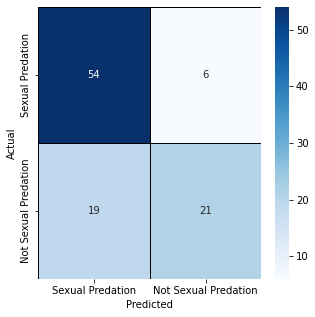

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data_test.Label, prediction_labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Sexual Predation','Not Sexual Predation'], 
            yticklabels = ['Sexual Predation','Not Sexual Predation'])
plt.xlabel("Predicted")
plt.ylabel("Actual")